# Exploring what influences Munich's AirBnB price

In the following notebook the AirBnB possibilities in Munich, Germany, will be discoverd regarding price and influencing factors.

The dataset is a snapshop of all available AirBnB listings in Munich, Germany at the 15 March, 2019. Additionaly the correspondings booking calendar is provided with the timeperiod from 15 March, 2019 until one year into the future.   

It was provied by Inside AirBnb - you can find more infomations and datasets from other cities under the following link: http://insideairbnb.com/get-the-data.html.

Following datasets are used:
* **listings.csv.gz**: Includes all AirBnB listings with about 100 attributes (e.g. price, ratring, location)
* **neighbourhoods.geojson**: Geodata of all neighbourhoods (districts)
* **calendar.csv.gz**: Current booking calendar - includes the prices and availability for the next year  

This is a beginner project of the Udacity Data Science Nanodegree program.

### Questions
1. Does the room type influence the price?
2. How's the interaction between price and location?
3. Are more and better rated (reviews) listings priecier?
4. Can hose specific data (e.g. superhost) have an influence on the price?
5. Price variations during the year (e.g. Oktoberfest) 

## 1. Dataset preparation

In [1]:
# import all needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import myutils as myu
import folium
from folium.features import DivIcon
from folium import plugins
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

### 1.1 Create dataset
In the following section covers the creation an preparation of the dataset for the analysis. This includes loading the dataset, choosing the right variables/categories and dealing with missing values.

In [2]:
# disable warning for chain assignment temporarily 
pd.set_option('mode.chained_assignment', None)

In [3]:
# load dataset with all AirBnB listings in Munich, Germany, time: 15 March 2019 
munich_listings_raw = pd.read_csv("./data/munich/listings.csv.gz", low_memory = False) 

In [4]:
# define all necessary categories
categories = ["id",
              "price",
              "neighbourhood_cleansed",
              "latitude",
              "longitude", 
              "review_scores_value", 
              "number_of_reviews",
              "room_type",
              "host_listings_count",
              "host_identity_verified",
              "host_verifications",
              "host_has_profile_pic",
              "host_is_superhost", 
              "instant_bookable" ]
# create dataset only with necessary variables/categories
munich_listings = munich_listings_raw[categories]
munich_listings.rename({"neighbourhood_cleansed": "neighbourhood"}, axis = "columns", inplace = True)
munich_listings.head()

,id,price,neighbourhood,latitude,longitude,review_scores_value,number_of_reviews,room_type,host_listings_count,host_identity_verified,host_verifications,host_has_profile_pic,host_is_superhost,instant_bookable
0,36720,$95.00,Ludwigsvorstadt-Isarvorstadt,48.13057,11.56929,9.0,25,Entire home/apt,1.0,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,f
1,97945,$80.00,Hadern,48.11476,11.48782,9.0,115,Entire home/apt,1.0,f,"['email', 'phone', 'reviews']",t,t,f
2,114695,$95.00,Berg am Laim,48.11923,11.63726,9.0,47,Entire home/apt,3.0,t,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,f
3,127383,$120.00,Maxvorstadt,48.15198,11.56486,10.0,75,Entire home/apt,2.0,t,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,f
4,159634,$55.00,Pasing-Obermenzing,48.13898,11.46612,9.0,27,Entire home/apt,1.0,t,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,f,t


In [5]:
# check if all datatypes have the correct type
munich_listings.dtypes

id                          int64
price                      object
neighbourhood              object
latitude                  float64
longitude                 float64
review_scores_value       float64
number_of_reviews           int64
room_type                  object
host_listings_count       float64
host_identity_verified     object
host_verifications         object
host_has_profile_pic       object
host_is_superhost          object
instant_bookable           object
dtype: object

In [6]:
# convert price from object to float
munich_listings[["price"]] = munich_listings[["price"]].replace("[\$,]", "", regex = True).astype(float)
# enable warning for chain assignment
pd.reset_option('mode.chained_assignment')

### 1.2 Check for missing values

In [7]:
# check if there are missing values in the dataset
categories_w_mising_values = myu.find_categories_w_missing_values(munich_listings)

No missing values in id
No missing values in price
No missing values in neighbourhood
No missing values in latitude
No missing values in longitude
Missing values in review_scores_value
No missing values in number_of_reviews
No missing values in room_type
Missing values in host_listings_count
Missing values in host_identity_verified
No missing values in host_verifications
Missing values in host_has_profile_pic
Missing values in host_is_superhost
No missing values in instant_bookable

There are 5 categories with missing values


### 1.3 Dealing with missing values
There missing values in 4 categories:
* review_scores_values
* review_scores_rating
* host_identity_verified
* host_is_superhost

Check how much values are missing:

In [8]:
myu.print_missing_values(munich_listings, categories_w_mising_values)

False    7330
True     2528
Name: review_scores_value, dtype: int64 

False    9852
True        6
Name: host_listings_count, dtype: int64 

False    9852
True        6
Name: host_identity_verified, dtype: int64 

False    9852
True        6
Name: host_has_profile_pic, dtype: int64 

False    9852
True        6
Name: host_is_superhost, dtype: int64 



About 34% of the dataset entries have missing values in the rating categories. The assumption is that these are the listings without any review. Thus the review will be used for the price prediction all rows with missing values will be removed from the dataset, because imputing the reviews would not make much sense. So all listings have at least one review, which furtermore indicates that this listing is real and exsits.  

In [9]:
# drop all listings with zero reviews
munich_listings = munich_listings.drop(munich_listings[munich_listings["number_of_reviews"] == 0].index)
myu.print_missing_values(munich_listings, categories_w_mising_values)

False    7330
True      185
Name: review_scores_value, dtype: int64 

False    7513
True        2
Name: host_listings_count, dtype: int64 

False    7513
True        2
Name: host_identity_verified, dtype: int64 

False    7513
True        2
Name: host_has_profile_pic, dtype: int64 

False    7513
True        2
Name: host_is_superhost, dtype: int64 



There are only a few rows (~2%) left with missing value. This negligible amount will also be removed.

In [10]:
for category in categories_w_mising_values:
    munich_listings = munich_listings.dropna(subset = [category], axis = 0)
myu.find_categories_w_missing_values(munich_listings)

No missing values in id
No missing values in price
No missing values in neighbourhood
No missing values in latitude
No missing values in longitude
No missing values in review_scores_value
No missing values in number_of_reviews
No missing values in room_type
No missing values in host_listings_count
No missing values in host_identity_verified
No missing values in host_verifications
No missing values in host_has_profile_pic
No missing values in host_is_superhost
No missing values in instant_bookable

There are 0 categories with missing values


[]

## 2. Data exploration
In the following section all above mentioned questions will be answered.

### 2.1 Does the room type influence the price?

In [11]:
# get unique room types
room_types = munich_listings["room_type"].unique()
print("There are", len(room_types), "unique room types:")
for room_type in room_types:
    print("*", room_type)

There are 3 unique room types:
* Entire home/apt
* Private room
* Shared room


In [12]:
# mean price of each room type
room_type_mean = munich_listings.groupby("room_type").mean()["price"]
room_type_mean

room_type
Entire home/apt    123.022222
Private room        70.754414
Shared room         66.050847
Name: price, dtype: float64

In [13]:
# count occurrence of each room type
room_type_vals = munich_listings["room_type"].value_counts()
room_type_vals

Entire home/apt    4095
Private room       3115
Shared room         118
Name: room_type, dtype: int64

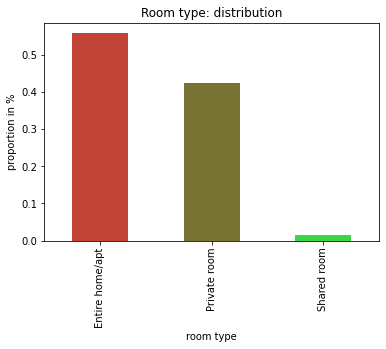

In [14]:
# bar chart: room type distribution
colors_room_type = myu.generate_random_colorlist(3)
(munich_listings["room_type"].value_counts()/munich_listings.shape[0]).plot(kind = "bar", color = colors_room_type)
plt.title("Room type: distribution");
plt.xlabel("room type");
plt.ylabel("proportion in %");
plt.savefig("./images/room_type_vs_proportion.png")

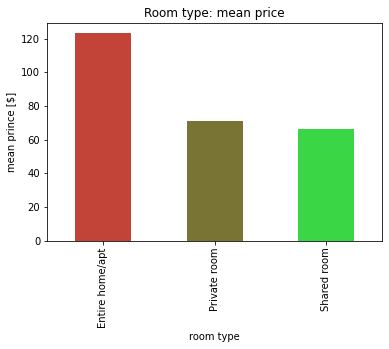

In [15]:
# bar chart: room type mean prices
(munich_listings.groupby("room_type").mean()["price"]).plot(kind = "bar", color = colors_room_type);
plt.title("Room type: mean price");
plt.xlabel("room type");
plt.ylabel("mean prince [$]");
plt.savefig("./images/room_type_vs_price.png")

**Result:** Most appartements (~55%) are from type "Entire home/apt" meaning you have the entire home for yourself. Assuming that the availability correlates with the demand, this room type is the 1st choice for people who book appartements with AirBnb. On the downside this categrory has the highest average price with ober 120$ per night.
Private rooms are the second popular of the three room types with a proportion of ~42%. The remaining percent listings are shared rooms. They seem to be the most unpopular room type, but it is interessing that the average price per night is only a bit lower than the price of private rooms. 
The type of a appartements room influences the price.

### 2.2 How's the interaction between price and location?

The assumption is, that the location of a AirBnB listings influences the price. If it is more central and near to specific tourist attractions or event locations the prices are higher than in the suburbs.  

In [16]:
# get unique neighbourhoods / districts
neighbourhoods = munich_listings["neighbourhood"].unique()
print("There are", len(neighbourhoods), "unique neighbourhoods/districts with AirBnb listings in Munich:")
for neighbourhood in neighbourhoods:
    print("*", neighbourhood)

There are 25 unique neighbourhoods/districts with AirBnb listings in Munich:
* Ludwigsvorstadt-Isarvorstadt
* Hadern
* Berg am Laim
* Maxvorstadt
* Pasing-Obermenzing
* Sendling-Westpark
* Untergiesing-Harlaching
* Schwabing-West
* Bogenhausen
* Au-Haidhausen
* Neuhausen-Nymphenburg
* Schwanthalerhöhe
* Tudering-Riem
* Sendling
* Schwabing-Freimann
* Ramersdorf-Perlach
* Feldmoching-Hasenbergl
* Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln
* Milbertshofen-Am Hart
* Obergiesing
* Altstadt-Lehel
* Laim
* Aubing-Lochhausen-Langwied
* Moosach
* Allach-Untermenzing


The following five districts are central:
* Altstat-Lehel
* Ludwigsvorstadt-Isarvorstadt
* Maxvorstadt
* Schwabing-Freimann
* Au-Haidhausen

In [17]:
central_districts = ["Altstadt-Lehel", "Ludwigsvorstadt-Isarvorstadt", "Maxvorstadt", "Schwabing-Freimann", "Au-Haidhausen"]
num_listings = 0
for district in central_districts:
    num_listings += len(munich_listings[munich_listings["neighbourhood"] == district])
print("In the 5 central districts, there are {:.2f}% of all AirBnB listings in Munich".format(num_listings/munich_listings.shape[0]*100))

In the 5 central districts, there are 37.39% of all AirBnB listings in Munich


In [18]:
central_avg_price = 0
for district in central_districts:
    central_avg_price += sum(munich_listings[munich_listings["neighbourhood"] == district]["price"])
central_avg_price /= num_listings
print("In the 5 central districts, there avererage price per night is {:.2f}$.".format(central_avg_price))
print("The overall average price per night is {:.2f}$ (median {:.2f}$)."
      .format(munich_listings["price"].mean(), munich_listings["price"].median()))

In the 5 central districts, there avererage price per night is 110.64$.
The overall average price per night is 99.89$ (median 75.00$).


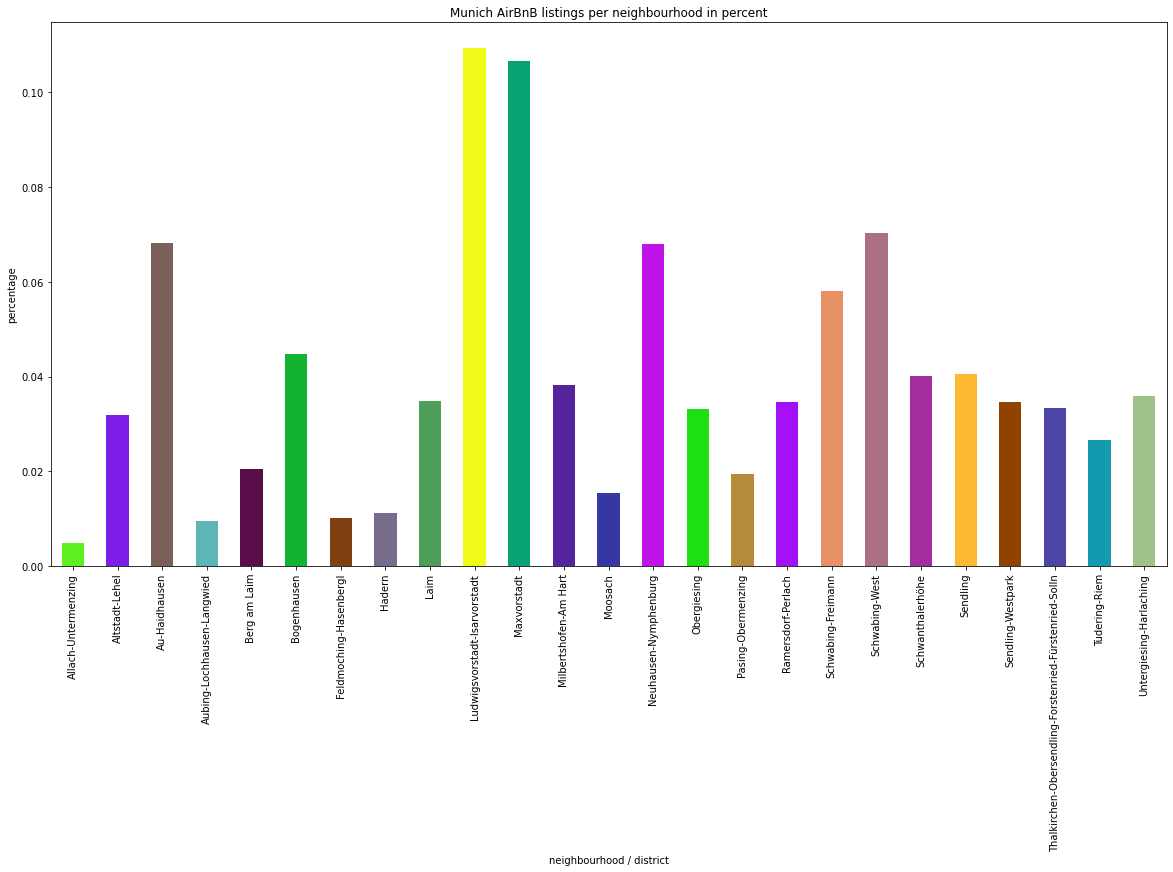

In [19]:
neighbourhood_vals = munich_listings["neighbourhood"].value_counts().sort_index() 
# bar chart: listings in neighbourhoods/districts
colors_neighbourhood = myu.generate_random_colorlist(len(neighbourhood_vals))
(neighbourhood_vals/munich_listings.shape[0]).plot(kind = "bar", figsize = (20,10), color = colors_neighbourhood);
plt.title("Munich AirBnB listings per neighbourhood in percent");
plt.ylabel("percentage");
plt.xlabel("neighbourhood / district");
plt.savefig("./images/neighbourhood_vs_availability.png")

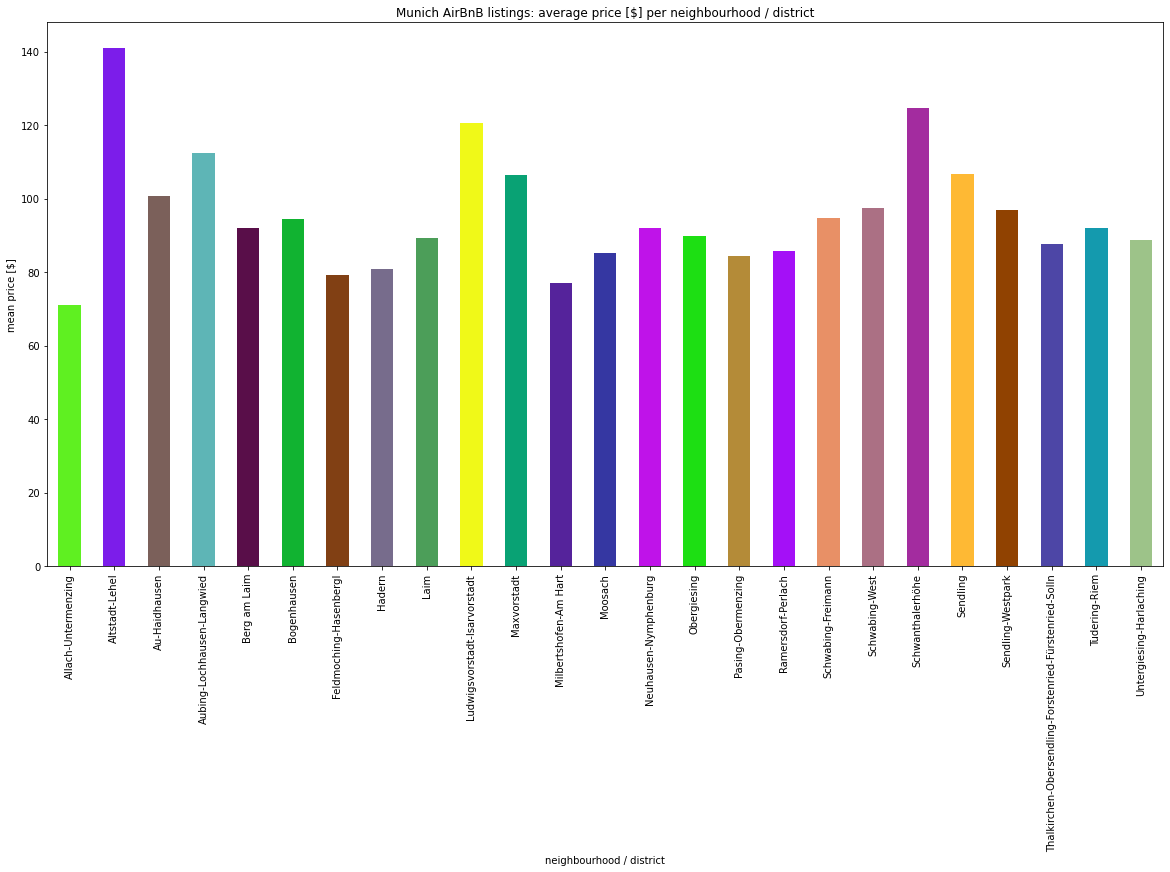

In [20]:
price_vals = munich_listings.groupby("neighbourhood").mean()["price"].sort_index()
# bar chart: mean price of AirBnB listings in Munich's districts
(price_vals).plot(kind = "bar", figsize = (20,10), color = colors_neighbourhood);
plt.title("Munich AirBnB listings: average price [$] per neighbourhood / district");
plt.ylabel("mean price [$]");
plt.xlabel("neighbourhood / district");
plt.savefig("./images/neighbourhood_vs_price.png")

##### Visualization of Munich's districts and the average price per night

In [21]:
munich_lat = munich_listings["latitude"].mean()
munich_long = munich_listings["longitude"].mean()
munich_neighbourhoods = "./data/munich/neighbourhoods.geojson"
munich_price = munich_listings.groupby(by = "neighbourhood").mean().reset_index()

# create a map with the geodata of Munich's districts with price as indicator
munich_map = folium.Map(location = [munich_lat, munich_long], zoom_start = 11, tiles = "Stamen Toner")
folium.Choropleth(
    geo_data = munich_neighbourhoods,
    name = 'choropleth',
    data = munich_price,
    columns = ['neighbourhood', 'price'],
    key_on = 'feature.properties.neighbourhood',
    fill_color = 'YlGn',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend = "Mean Price (Euro)"
).add_to(munich_map)

folium.LayerControl().add_to(munich_map)
munich_map

**Result**: As shown previously the central districts are pricier than the suburbs.

##### Visualization of location the pricienst and cheaptest listings

In [22]:
munich_map_price = folium.Map(location = [munich_lat, munich_long], zoom_start = 12, tiles = 'Stamen Toner')

n = int(munich_listings.shape[0]*0.10) # 10% of all listings
munich_price_high = munich_listings[["latitude", "longitude", "price"]].nlargest(n, "price")
munich_price_low = munich_listings[["latitude", "longitude", "price"]].nsmallest(n, "price")

print("Pricienst listungs descriptives\n", munich_price_high["price"].describe())
print("\nCheapest listings descriptives\n", munich_price_low["price"].describe())

# mark n priciest listings
for index, row in munich_price_high.iterrows():
    label = folium.Popup(f'{index}\n{row["price"]:.2f} $')
    folium.CircleMarker(
        [row["latitude"], row["longitude"]],
        radius = 5,
        popup = label,
        color = "red",
        fill = True,
        fill_color = "red",
        fill_opacity = 0.2,
        parse_html = False).add_to(munich_map_price)
# mark n cheapest listings
for index, row in munich_price_low.iterrows():
    label = folium.Popup(f'{index}\n{row["price"]:.2f} $')
    folium.CircleMarker(
        [row["latitude"], row["longitude"]],
        radius = 5,
        popup = label,
        color = "green",
        fill = True,
        fill_color = "green",
        fill_opacity = 0.2,
        parse_html = False).add_to(munich_map_price)  
    
munich_map_price

Pricienst listungs descriptives
 count     732.000000
mean      303.263661
std       165.144368
min       189.000000
25%       200.000000
50%       250.000000
75%       320.000000
max      2250.000000
Name: price, dtype: float64

Cheapest listings descriptives
 count    732.000000
mean      30.413934
std        5.391839
min        8.000000
25%       28.000000
50%       30.000000
75%       35.000000
max       38.000000
Name: price, dtype: float64


**Result:** This visualitation matches with alle the previous shown findings. 
* The 5 central districts includes a large amount of the pricier listings (higher average price per night)
* The 5 central districts cover 36.58% of all listings (more listings in all price categories)
* The cheaper listings have a larger distance to the center

##### Heatmap visualization of the room type and location: Entire home/appartement

In [23]:
heatmap = folium.Map(location=[munich_lat, munich_long], zoom_start = 12, tiles = 'Stamen Toner')
room_type_entire_home = munich_listings[munich_listings["room_type"] == "Entire home/apt"][["latitude", "longitude"]].values
heatmap.add_child(folium.plugins.HeatMap(room_type_entire_home, radius = 15))
heatmap

##### Heatmap visualization of the room type and location: Private room

In [24]:
heatmap = folium.Map(location=[munich_lat, munich_long], zoom_start = 12, tiles = 'Stamen Toner',)
room_type_private = munich_listings[munich_listings["room_type"] == "Private room"][["latitude", "longitude"]].values
heatmap.add_child(folium.plugins.HeatMap(room_type_private, radius = 15))
heatmap

##### Heatmap visualization of the room type and location: Shared room

In [25]:
heatmap = folium.Map(location=[munich_lat, munich_long], zoom_start = 12, tiles = 'Stamen Toner',)
room_type_shared = munich_listings[munich_listings["room_type"] == "Shared room"][["latitude", "longitude"]].values
heatmap.add_child(folium.plugins.HeatMap(room_type_shared, radius = 15))
heatmap

### 2.3 Are more and better reviewed listings pricier?

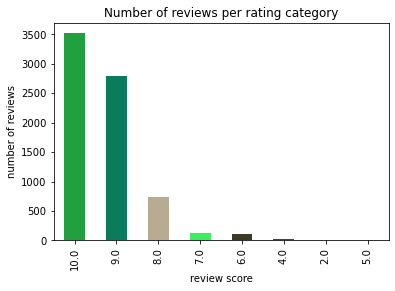

In [26]:
# bar char: number of reviewes per category
colors_review = myu.generate_random_colorlist(10)
(munich_listings["review_scores_value"].value_counts()).plot(kind = "bar", color = colors_review);
plt.title("Number of reviews per rating category");
plt.xlabel("review score");
plt.ylabel("number of reviews");
plt.savefig("./images/number_of_reviews_vs_scores.png")

In [27]:
munich_listings["review_scores_value"].describe()

count    7328.000000
mean        9.269651
std         0.942540
min         2.000000
25%         9.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: review_scores_value, dtype: float64

In [28]:
result = len(munich_listings[munich_listings["review_scores_value"] >= 9])/munich_listings.shape[0]*100
print("Most of the listings ({:.2f}%) have a rating of 8 or higher".format(result))

Most of the listings (86.15%) have a rating of 8 or higher


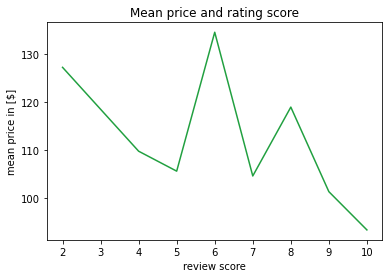

In [29]:
# line plot: mean price per rating score
(munich_listings.groupby("review_scores_value").mean())["price"].plot(color = colors_review);
plt.title("Mean price and rating score");
plt.xlabel("review score");
plt.ylabel("mean price in [$]");
plt.savefig("./images/review_score_vs_price.png")

It is interessting that the lowest mean prirce ~55\\$ per night leads to the socre of 5 and a mean price of ~100\\$ per night to the highest rating. The reason for that is shown in the boxplot below:

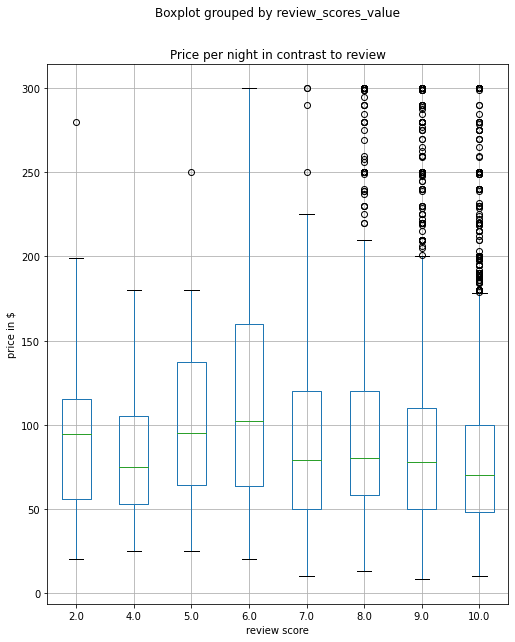

In [30]:
# for visualization purposes only prives below 300$ per night will be used for the boxplot
munich_listings_box = munich_listings.drop(munich_listings[munich_listings["price"] > 300].index)
munich_listings_box.boxplot(column = ["price"], by = ["review_scores_value"], figsize = (8,10));
plt.title("Price per night in contrast to review");
plt.xlabel("review score");
plt.ylabel("price in $");
plt.savefig("./images/number_of_reviews_vs_price_boxplot.png")

Due to a large amout of outliers the mean prices in for the ratings 8, 9 and 10 are relatively low. One can say that listings with a price of ~200$ per night have at least a rating of 8.

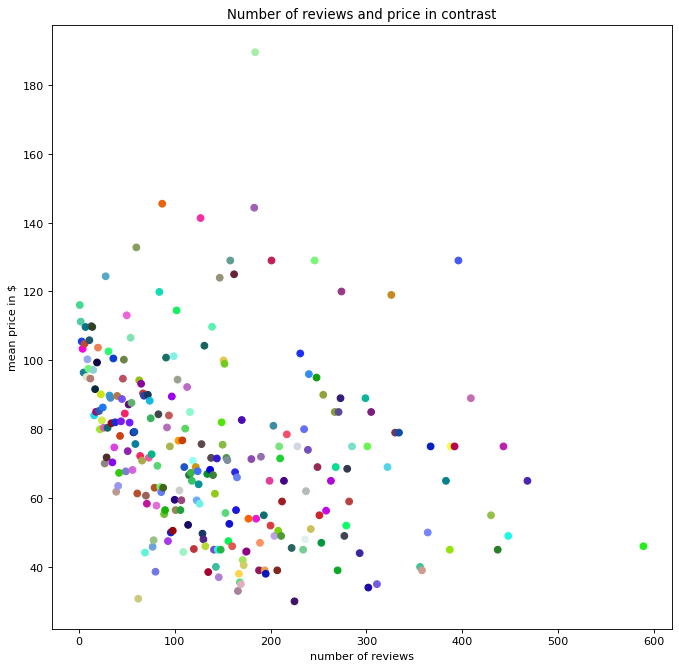

In [31]:
reviews = munich_listings.groupby("number_of_reviews").mean()["price"]
plt.figure(figsize = (10, 10), dpi = 80)
plt.scatter(reviews.index, reviews, color = myu.generate_random_colorlist(len(reviews)));
plt.title("Number of reviews and price in contrast");
plt.xlabel("number of reviews");
plt.ylabel("mean price in $");
plt.savefig("./images/number_of_reviews_vs_price.png")

The scatterplot above shows that more reviews do not necessarily lead to higher prices. The calculations below shows that 184 reviews leads to the hightest average prive per night (189.5\\$). And the maximum number of reviews (589) only to a price of 46\\$ per night.
On average a listing has 19.58 reviews and a mean price of 99.89\\$ per night.

In [32]:
# calculate number of reviews with leads to the highest average price per night
reviews_price = munich_listings.groupby("number_of_reviews").mean()
reviews_price[reviews_price["price"] == reviews_price["price"].max()]

,id,price,latitude,longitude,review_scores_value,host_listings_count
number_of_reviews,,,,,,
184,11254015.5,189.5,48.14002,11.56743,9.0,8.0


In [33]:
# price per night for the maximum number of revies
reviews_price["price"].tail(1)

number_of_reviews
589    46.0
Name: price, dtype: float64

In [34]:
# calculate means for number of ratings and price
print("Average number of reviews: {:.2f}".format(munich_listings["number_of_reviews"].mean()))
print("Average price per night: {:.2f} $ ".format(munich_listings["price"].mean()))

Average number of reviews: 19.58
Average price per night: 99.89 $ 


### 2.4 Can hose specific data (e.g. superhost) have an influence on the price?

##### Host specific data: Superhost

In [35]:
munich_listings.groupby("host_is_superhost").describe()["price"]

,count,mean,std,min,25%,50%,75%,max
host_is_superhost,,,,,,,,
f,6127.0,102.874000,96.265534,8.0,50.0,79.0,119.0,2250.0
t,1201.0,84.646961,67.184239,17.0,45.0,65.0,99.0,945.0


In [36]:
print("About {:.2f} of all hosts are not superhosts.".format(1-1201/munich_listings.shape[0]))
print("The average price (102.87$) are above the superhosts average price (84.64$), price difference is 21.52%")

About 0.84 of all hosts are not superhosts.
The average price (102.87$) are above the superhosts average price (84.64$), price difference is 21.52%


#### Host specific data: host_identity_verified

In [37]:
munich_listings.groupby("host_identity_verified").describe()["price"]

,count,mean,std,min,25%,50%,75%,max
host_identity_verified,,,,,,,,
f,4597.0,99.604090,88.768589,8.0,50.0,77.0,115.0,1120.0
t,2731.0,100.362505,98.157400,14.0,50.0,75.0,110.0,2250.0


In [38]:
print("About {:.2f} of all hosts have a verified id.".format(2731/munich_listings.shape[0]))
print("There are no relevant influence on the price")

About 0.37 of all hosts have a verified id.
There are no relevant influence on the price


#### Host specific data: host_listings_count

In [39]:
munich_listings.groupby("host_listings_count").describe()["price"]

,count,mean,std,min,25%,50%,75%,max
host_listings_count,,,,,,,,
0.0,10.0,110.400000,74.992148,35.0,65.00,87.0,123.75,300.0
1.0,5454.0,99.697836,91.068632,10.0,50.00,79.0,114.75,2250.0
2.0,1044.0,99.777778,89.425129,8.0,49.00,75.0,119.25,1000.0
3.0,340.0,95.629412,93.152353,10.0,45.00,69.0,109.00,800.0
4.0,150.0,124.686667,143.589559,25.0,49.00,78.5,120.00,800.0
5.0,65.0,112.430769,110.222073,19.0,39.00,79.0,125.00,550.0
6.0,48.0,88.562500,73.620911,29.0,44.50,64.5,101.50,450.0
7.0,28.0,91.857143,92.356280,20.0,44.25,64.0,104.75,490.0
8.0,30.0,91.666667,89.710774,25.0,30.50,69.5,130.00,500.0


If a host has 15 listings the mean price is at its maximum of 249.87\\$. More listings do not necessarily lead to a higher price. Most hosts only offer one listing. A assumption is that if a host has that much listings its a professional provider and is specialized on a certrain type of appartement with high standards and furnishing. 

#### Host specific data: host_has_profile_pic

In [40]:
munich_listings.groupby("host_has_profile_pic").describe()["price"]

,count,mean,std,min,25%,50%,75%,max
host_has_profile_pic,,,,,,,,
f,20.0,75.950000,31.224948,25.0,53.75,80.0,92.5,140.0
t,7308.0,99.952244,92.477440,8.0,50.00,75.0,115.0,2250.0


Only 0.27% of all hosts have no profile pic. All hosts without a profile pic have a lower average price per night - the price is reduced by about one quarter comparted to the hosts with profile pic. 

#### Host specific data: host_response_time 
The host_response_time wasn't included on purpose in the former used munich_listings dataset because of the high number of missing values.

In [41]:
# create dataset for response time with price and review score
response_time = munich_listings_raw[["price", "host_response_time", "review_scores_value"]]
# convert price into float
pd.set_option('mode.chained_assignment',None)
response_time[["price"]] = response_time[["price"]].replace("[\$,]", "", regex = True).astype(float)
pd.reset_option('mode.chained_assignment')
# drop all rows with missing values
categories_w_mising_values = myu.find_categories_w_missing_values(response_time, print_values = False)
for category in categories_w_mising_values:
    response_time = response_time.dropna(subset = [category], axis = 0)

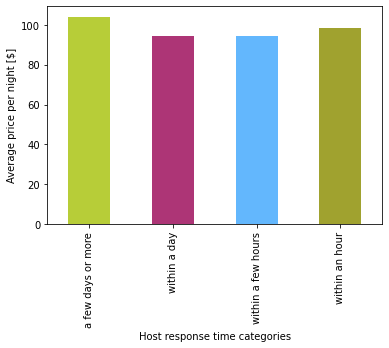

In [42]:
color_list = myu.generate_random_colorlist(len(response_time["host_response_time"].unique()));
(response_time.groupby("host_response_time").mean()["price"]).plot(kind = "bar", color = color_list);
plt.xlabel("Host response time categories");
plt.ylabel("Average price per night [$]");
plt.savefig("./images/host_response_time_vs_price.png")

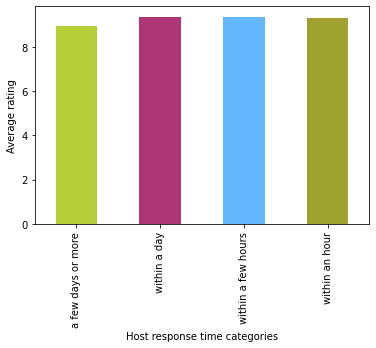

In [43]:
(response_time.groupby("host_response_time").mean()["review_scores_value"]).plot(kind = "bar", color = color_list);
plt.xlabel("Host response time categories");
plt.ylabel("Average rating");
plt.savefig("./images/host_response_time_vs_rating.png")

In [44]:
response_time.groupby("host_response_time").describe()

price                                                    \
                     count        mean         std   min    25%   50%    75%   
host_response_time                                                             
a few days or more   214.0  104.093458   99.316021  12.0  57.25  80.0  110.0   
within a day        1068.0   94.333333   73.215012  15.0  50.00  75.0  110.0   
within a few hours  1062.0   94.491525   84.841458  10.0  48.00  70.0  105.0   
within an hour      1913.0   98.439101  103.568018   8.0  49.00  70.0  110.0   

                           review_scores_value                                \
                       max               count      mean       std  min  25%   
host_response_time                                                             
a few days or more  1000.0               214.0  8.948598  1.346940  2.0  9.0   
within a day         800.0              1068.0  9.361423  0.778393  2.0  9.0   
within a few hours   950.0              1062.0  9.333333  0.806430  2.0  9.0   
within an hour      2250.0              1913.0  9.321485  0.774626  2.0  9.0   

                                     
                    50%   75%   max  
host_response_time                   
a few days or more  9.0  10.0  10.0  
within a day        9.0  10.0  10.0  
within a few hours  9.0  10.0  10.0  
within an hour      9.0  10.0  10.0

**Result:** A same day response leads to slightly better reviews but even if the response time is a few days or more the average review score is still 8.94 and also the average price in this case if the hightest. The reason for that might be that more exclusive and therefore pricier apparements have no instand booking option, so that the host can select its guests beforehand.

### 2.5. Price variations during the year (e.g. Oktoberfest)
*Hint: For the price evaluation during the year the booking calendar is used. This dataset gives information about the prices and availabilities from the current date (15 March 2019) until one year in the future (15 Mar 2020).
This is only a snapshopt of the booking calendar and does not provide any infomration about the real occurences of bookings and prices. The real prices during the year and also the number of listings can be vary during the year.*

In the following section the price variations during the year will be discoverd. Especially if events like the Oktoberfest have an impact on the prices.

In [45]:
# map of munich wich geodata and the location of the Oktoberfest
munich_map_oktoberfest = munich_map
# add the circle marker of the Oktoberfest to the map
folium.CircleMarker(
    location=[48.13084068072524, 11.550180677497941],
    radius=15,
    popup="Oktoberfest",
    color="#ff0000",
    fill=True,
    fill_color="#3186cc",
).add_to(munich_map_oktoberfest)
# add text to the map 
folium.map.Marker(
    [48.12574068072524, 11.510180677497941],
    icon=DivIcon(
        icon_size=(100,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 14pt;color:#E72F2F;font-family:courier"><b>Oktoberfest<b></div>',
        )
    ).add_to(munich_map_oktoberfest)

munich_map_oktoberfest

In [46]:
# read and prepare the calendar dataset
munich_calendar = pd.read_csv("./data/munich/calendar.csv.gz", parse_dates= ['date']);
# convert the prices into float values
munich_calendar["price"] = munich_calendar[["price"]].replace("[\$,]", "", regex=True).astype(float)
munich_calendar["adjusted_price"] = munich_calendar[["adjusted_price"]].replace("[\$,]", "", regex=True).astype(float)
munich_calendar.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,8296281,2019-03-15,f,99.0,99.0,1.0,1125.0
1,8296281,2019-03-16,f,99.0,99.0,1.0,1125.0
2,8296281,2019-03-17,f,99.0,99.0,1.0,1125.0


In [47]:
munich_calendar.dtypes

listing_id                 int64
date              datetime64[ns]
available                 object
price                    float64
adjusted_price           float64
minimum_nights           float64
maximum_nights           float64
dtype: object

In [48]:
# create a list for the correct ordering of the month 
order_list = []
# week 13 to 53 in year 2019
for i in range(13, 53):
    order_list.append(i)
# week 1 to 12 in year 2020
for i in range(1, 13):
    order_list.append(i)

Overall average price during the year: 110.75 $


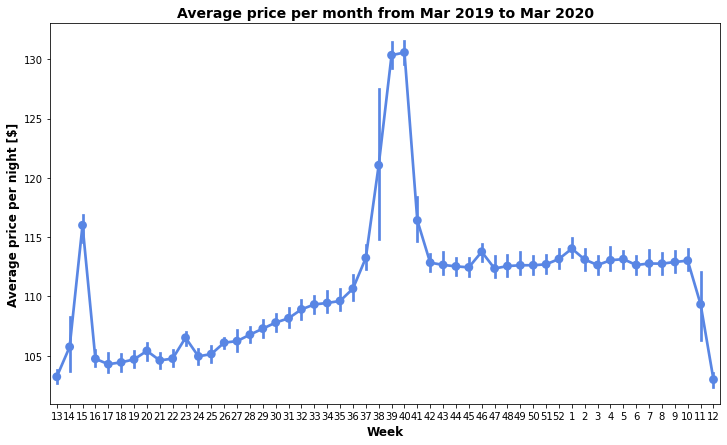

In [49]:
# get the mean price per day from the booking calendar
munich_calendar_week = munich_calendar.groupby(pd.Grouper(key = 'date',freq ='1D')).mean()

# visualization of the prices during the year (timeperiod: Mar 2019 to Mar 2020)
plt.figure(figsize = (12, 7))
sns.pointplot(x = munich_calendar_week.index.isocalendar().week, y = munich_calendar_week["price"], color= '#5986e4', order = order_list)
plt.title('Average price per month from Mar 2019 to Mar 2020',fontsize = 14, weight = 'bold')
plt.xlabel('Week', fontsize = 12, weight = 'bold')
plt.ylabel('Average price per night [$]', fontsize = 12, weight = 'bold')
plt.savefig("./images/price_per_month.png")
print("Overall average price during the year: {:.2f} $".format(np.mean(munich_calendar_week.price)))

**Result:** As seen in the diagram abobe, there are price variation during the year and there are two peaks. 
* Peak 1 - from week #14 to #16: The reason for this peak could be Eastern, which was at 21. March 2019 (week 16). 


* Peak 2 - from week #37 to #41: This peak fits to the time of the Oktoberfest which was from 21. Sept 2019 to 06. Oct 2019, which corressponds to the weeks 39 and 40.

### 3. Price prediction with a linear regression model

In [50]:
# get subset of dataset munich_listings for creating a linear model
munich_listings_LM = munich_listings[["id",
                                      "price",
                                      "neighbourhood",
                                      "latitude",
                                      "longitude", 
                                      "review_scores_value", 
                                      "number_of_reviews",
                                      "room_type",
                                      "host_listings_count",
                                      "host_identity_verified",
                                      "host_has_profile_pic",
                                      "host_is_superhost", 
                                      "instant_bookable" 
                                     ]]

# create dummy variables for all categorial variables
munich_listings_dummies = myu.create_dummy_variables(munich_listings_LM)

# create dependent and independent variable
X = munich_listings_dummies.drop(["id", "price"], axis=1)
y = munich_listings_dummies["price"]

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)

# instantiate and fit linear regression model
lm_model = LinearRegression(normalize = True) 
lm_model.fit(X_train, y_train) 

# prededict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print("The rsquared on the training data was {}.\nThe rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.12142314818300814.
The rsquared on the test data was 0.10334874226236701.


The r-squared value on the training data is 12.14% and the r-squared value on the test data is 10.33%. This is obviously not the best model but it shows that the used variables especialls the neighbourhood can be used to predict prices. Another model and maybe also a larger amount of data, e.g. the AirBnB listings of serveral years in combination with the calendar data, would improve this result.